In [1]:
import os
import glob
import pandas as pd
from datetime import datetime, timezone
import json
from pandas import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc

folder_path = 'openngo_2021_26_08'

# Список всех файлов .json в папке
json_files = glob.glob(os.path.join(folder_path, '*.json'))

# Размер чанка (количество строк для чтения за один раз)
chunk_size = 1000

# Инициализация пустого списка для хранения данных
all_data = []

# Цикл по всем файлам .json и их объединение
for json_file in json_files:
    # Чтение данных по частям
    chunks = pd.read_json(json_file, lines=True, chunksize=chunk_size)
    
    for chunk in chunks:
        all_data.append(chunk)

# Объединение чанков в один DataFrame
data = pd.concat(all_data, ignore_index=True)

C:\Users\Radmin\AppData\Local\Temp\ipykernel_8608\2691121640.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Просмотр первых нескольких строк данных
print(data.head())

# Просмотр общей информации о данных
print(data.info())

# Просмотр статистических характеристик числовых данных
print(data.describe())

  minjustRegNum       regionName  logo  \
0    7814061218  Санкт-Петербург   NaN   
1    7714017452           Москва   NaN   
2    7814170160  Санкт-Петербург   NaN   
3          None           Москва   NaN   
4    7814052913  Санкт-Петербург   NaN   

                                        statusDetail  \
0  {'name': None, 'code': None, 'shortName': 'Дей...   
1  {'name': None, 'code': None, 'shortName': 'Дей...   
2  {'name': None, 'code': None, 'shortName': 'Дей...   
3  {'name': None, 'code': None, 'shortName': 'Дей...   
4  {'name': None, 'code': None, 'shortName': 'Дей...   

                                            fullName dateReg  \
0  МЕЖРЕГИОНАЛЬНАЯ АНТРОПОСОФСКАЯ МЕДИЦИНСКАЯ АСС...    None   
1  ФОНД "СОДЕЙСТВИЕ ДУХОВНОМУ РАЗВИТИЮ ЧЕЛОВЕКА "...    None   
2  КОЛЛЕГИЯ АДВОКАТОВ "САНКТ-ПЕТЕРБУРГСКАЯ КОЛЛЕГ...    None   
3  ТОВАРИЩЕСТВО СОБСТВЕННИКОВ НЕДВИЖИМОСТИ "ЛУГИН...    None   
4  АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ "ЦЕНТР С...    None   

                         

In [3]:
# Рассмотрим типы данных каждого признака
print(data.dtypes)

minjustRegNum          object
regionName             object
logo                  float64
statusDetail           object
fullName               object
dateReg                object
minjustForm            object
charter               float64
minjustStatus          object
ogrn                    int64
opf                    object
oktmo                  object
egrulStatus            object
mainOkved              object
regionCode              int64
incomeTotal           float64
email                  object
incomeDetail           object
administrators         object
inn                   float64
okpo                  float64
originDate             object
website                object
dateLiquid             object
address                object
successors             object
okogu                  object
kpp                   float64
hasRegionalSupport       bool
addOkved               object
okato                  object
okfs                   object
website_punycode       object
shortName 

                    Missing Values  Missing Percentage
minjustRegNum               284732           38.114999
regionName                      25            0.003347
logo                        747034          100.000000
statusDetail                     0            0.000000
fullName                         0            0.000000
dateReg                     425618           56.974381
minjustForm                 284732           38.114999
charter                     747034          100.000000
minjustStatus               284732           38.114999
ogrn                             0            0.000000
opf                              0            0.000000
oktmo                            0            0.000000
egrulStatus                      0            0.000000
mainOkved                        0            0.000000
regionCode                       0            0.000000
incomeTotal                      0            0.000000
email                       738876           98.907948
incomeDeta

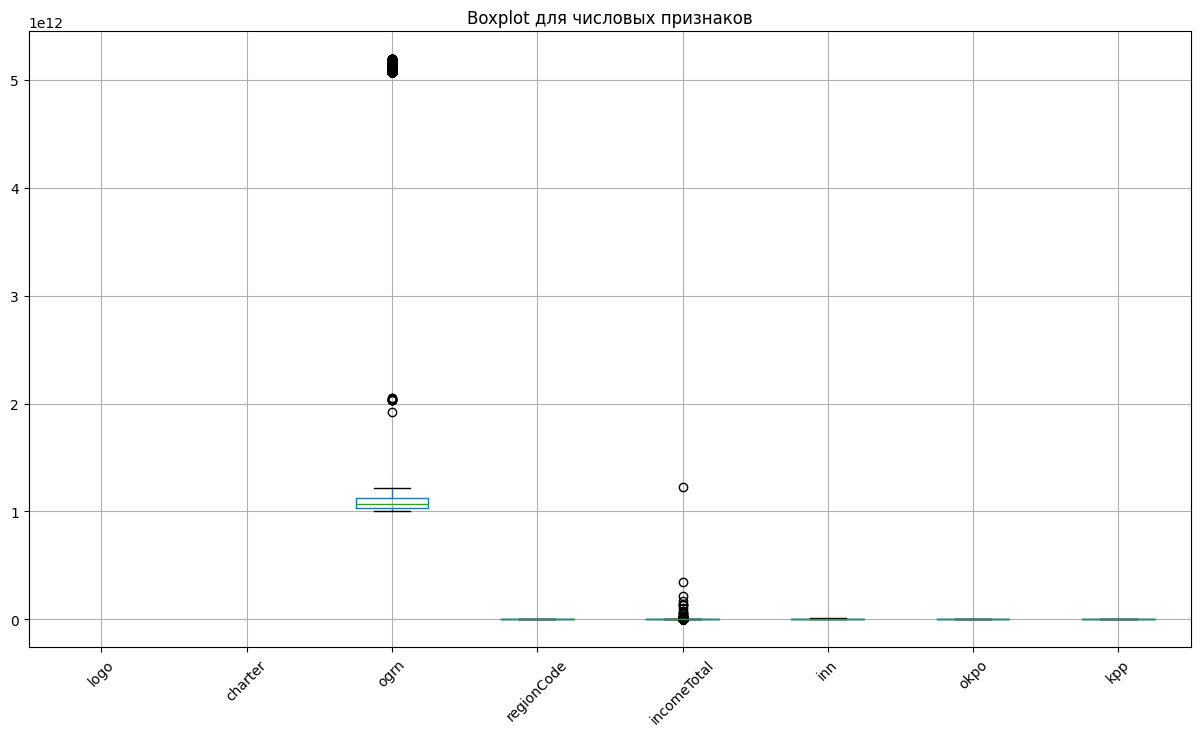

In [4]:
# Определим количество и долю отсутствующих значений по каждому признаку
missing_values = data.isnull().sum()
missing_percent = (missing_values / len(data)) * 100
missing_info = pd.DataFrame({'Missing Values': missing_values, 'Missing Percentage': missing_percent})
print(missing_info)

# Исследуем числовые признаки на предмет выбросов
numeric_features = data.select_dtypes(include=[np.number])
numeric_features.boxplot(rot=45, figsize=(15, 8))
plt.title("Boxplot для числовых признаков")
plt.show()

Графики ящиков с подбором показывают наличие выбросов в числовых признаках, таких как incomeTotal

### Предварительный анализ данных:

1. **Описание данных:**
   - Данные включают различные характеристики организаций, такие как регистрационный номер, регион, статус, дата регистрации, форма организации, доходы и другие.

2. **Пропущенные значения:**
   - В данных присутствуют пропущенные значения, например, в столбцах `minjustRegNum`, `regionName`, `logo`, `dateReg`, `minjustForm`, `charter`, `minjustStatus`, `email`, `inn`, `okpo`, `website`, `dateLiquid`. Некоторые столбцы имеют 100% пропущенных значений (например, `logo`, `charter`), что следует учитывать при анализе.

3. **Типы данных:**
   - Потребуется преобразование типов данных, например, `dateReg` и `dateLiquid` следует преобразовать в формат даты, а некоторые столбцы, такие как `inn` и `okpo`, имеют тип float64, что может быть неудобно для идентификации.

### Исследование зависимости вероятности получения грантов:

4. **Анализ числовых признаков:**
   - Графики ящиков с подбором показывают наличие выбросов в числовых признаках, таких как `incomeTotal`.

5. **Корреляционный анализ:**
   - Необходимо провести корреляционный анализ между числовыми признаками, чтобы выявить возможные зависимости.

In [5]:
# Удаление столбцов с нулевым количеством непустых значений
data = data.dropna(axis=1, how='all')

# Проверка столбцов с пропущенными значениями после удаления
missing_values_after_removal = data.isnull().sum()
print(missing_values_after_removal[missing_values_after_removal > 0])

minjustRegNum       284732
regionName              25
dateReg             425618
minjustForm         284732
minjustStatus       284732
email               738876
inn                   2604
okpo                399597
website             741748
dateLiquid          347073
kpp                   3662
website_punycode    741748
shortName           149241
dtype: int64


Проведем корреляционный анализ между числовыми признаками, чтобы выявить возможные зависимости.

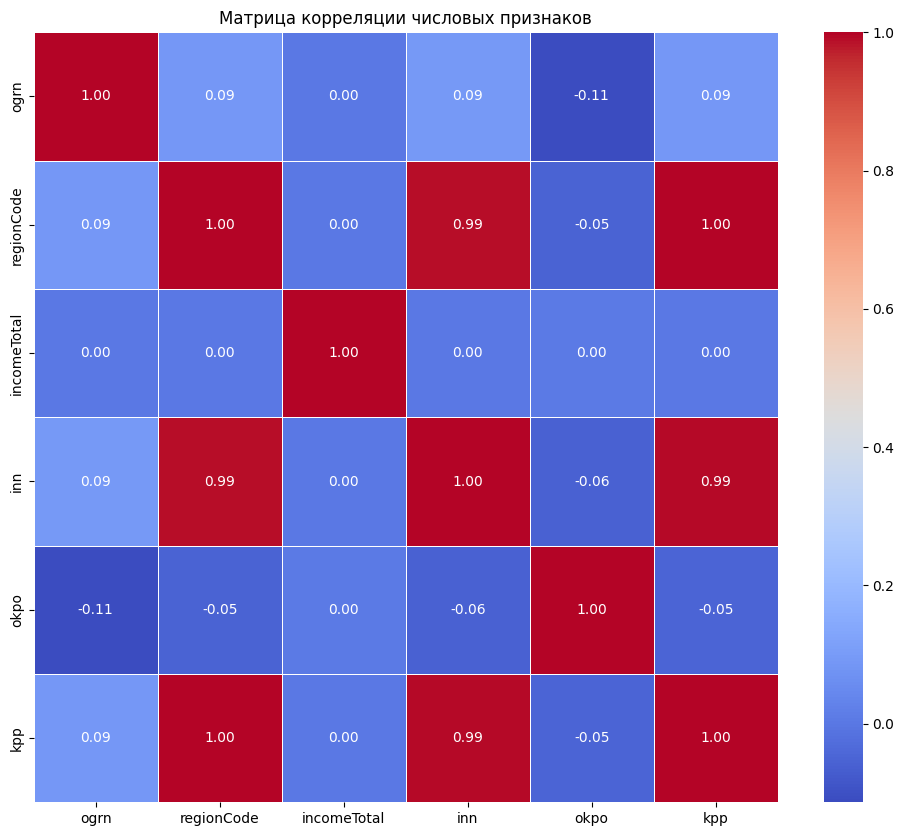

In [6]:
# Выберем только числовые признаки
numeric_features = data.select_dtypes(include=[np.number])

# Построим матрицу корреляции
correlation_matrix = numeric_features.corr()

# Создадим тепловую карту для визуализации корреляций
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Матрица корреляции числовых признаков')
plt.show()

В некоторых столбцах содержатся данные, представленные в виде словарей. Просмотрим структуру словарей в нескольких столбцах:

    statusDetail: Структура, которая, вероятно, содержит дополнительные детали о статусе организации.
    opf: Структура, которая, вероятно, представляет форму собственности организации.
    mainOkved: Структура, представляющая основной вид экономической деятельности организации.
    incomeDetail: Структура, содержащая информацию о доходах организации по различным источникам.

In [7]:
# Пример структуры словаря в столбце 'statusDetail'
print(data['statusDetail'].head(1))

# Пример структуры словаря в столбце 'opf'
print(data['opf'].head(1))

# Пример структуры словаря в столбце 'mainOkved'
print(data['mainOkved'].head(1))

# Пример структуры словаря в столбце 'incomeDetail'
print(data['incomeDetail'].head(1))

0    {'name': None, 'code': None, 'shortName': 'Дей...
Name: statusDetail, dtype: object
0    {'name': 'Ассоциации (союзы)', 'code': '20600'...
Name: opf, dtype: object
0    {'name': 'Деятельность профессиональных членск...
Name: mainOkved, dtype: object
0    {'grants': {'totalCount': 0, 'totalSum': 0}, '...
Name: incomeDetail, dtype: object


Определим ключевые поля, которые могут быть полезны для нашего анализа:

1. **statusDetail:**
   - 'shortName': Краткое наименование статуса организации.

2. **opf:**
   - 'name': Наименование формы собственности.

3. **mainOkved:**
   - 'name': Наименование основного вида экономической деятельности.

4. **incomeDetail:**
   - 'grants': {'totalCount': Количество грантов, 'totalSum': Общая сумма грантов}.
   - 'fedSubsidies': {'totalCount': Количество федеральных субсидий, 'totalSum': Общая сумма федеральных субсидий}.
   - 'contracts44': {'totalCount': Количество контрактов по 44-ФЗ, 'totalSum': Общая сумма контрактов по 44-ФЗ}.
   - 'contracts223': {'totalCount': Количество контрактов по 223-ФЗ, 'totalSum': Общая сумма контрактов по 223-ФЗ}.
   - 'contracts94': {'totalCount': Количество контрактов по 94-ФЗ, 'totalSum': Общая сумма контрактов по 94-ФЗ}.

Теперь мы знаем, какие ключевые поля мы можем извлечь из словарей в этих столбцах. Эти данные могут быть полезными для дальнейшего анализа зависимости вероятности получения грантов от государства/госконтрактов.

In [8]:
# Извлечение данных из столбца 'statusDetail'
data['status'] = data['statusDetail'].apply(lambda x: x.get('shortName', None))

# Извлечение данных из столбца 'opf'
data['opf_name'] = data['opf'].apply(lambda x: x.get('name', None))

# Извлечение данных из столбца 'mainOkved'
data['mainOkved_name'] = data['mainOkved'].apply(lambda x: x.get('name', None))

# Извлечение данных из столбца 'incomeDetail'
data['grants_count'] = data['incomeDetail'].apply(lambda x: x.get('grants', {}).get('totalCount', None))
data['grants_total_sum'] = data['incomeDetail'].apply(lambda x: x.get('grants', {}).get('totalSum', None))
data['fedSubsidies_count'] = data['incomeDetail'].apply(lambda x: x.get('fedSubsidies', {}).get('totalCount', None))
data['fedSubsidies_total_sum'] = data['incomeDetail'].apply(lambda x: x.get('fedSubsidies', {}).get('totalSum', None))
data['contracts44_count'] = data['incomeDetail'].apply(lambda x: x.get('contracts44', {}).get('totalCount', None))
data['contracts44_total_sum'] = data['incomeDetail'].apply(lambda x: x.get('contracts44', {}).get('totalSum', None))
data['contracts223_count'] = data['incomeDetail'].apply(lambda x: x.get('contracts223', {}).get('totalCount', None))
data['contracts223_total_sum'] = data['incomeDetail'].apply(lambda x: x.get('contracts223', {}).get('totalSum', None))
data['contracts94_count'] = data['incomeDetail'].apply(lambda x: x.get('contracts94', {}).get('totalCount', None))
data['contracts94_total_sum'] = data['incomeDetail'].apply(lambda x: x.get('contracts94', {}).get('totalSum', None))

# Вывод первых нескольких строк с новыми столбцами
print(data[['status', 'opf_name', 'mainOkved_name', 'grants_count', 'grants_total_sum',
            'fedSubsidies_count', 'fedSubsidies_total_sum', 'contracts44_count', 'contracts44_total_sum',
            'contracts223_count', 'contracts223_total_sum', 'contracts94_count', 'contracts94_total_sum']].head())

        status                                 opf_name  \
0  Действующая                       Ассоциации (союзы)   
1  Действующая                                    Фонды   
2  Действующая                       Коллегии адвокатов   
3  Действующая  Товарищества собственников недвижимости   
4  Действующая    Автономные некоммерческие организации   

                                      mainOkved_name  grants_count  \
0  Деятельность профессиональных членских организ...             0   
1  Предоставление прочих финансовых услуг, кроме ...             0   
2                       Деятельность в области права             0   
3  Управление недвижимым имуществом за вознагражд...             0   
4  Деятельность по организации конференций и выст...             0   

   grants_total_sum  fedSubsidies_count  fedSubsidies_total_sum  \
0               0.0                   0                     0.0   
1               0.0                   0                     0.0   
2               0.0    

## Заполним пропущенные значения

In [9]:
# Заполнение пропущенных значений
data['minjustRegNum'].fillna('unknown', inplace=True)
data['regionName'].fillna(data['regionName'].mode()[0], inplace=True)
data['minjustForm'].fillna(data['minjustForm'].mode()[0], inplace=True)
data['minjustStatus'].fillna(data['minjustStatus'].mode()[0], inplace=True)
data['email'].fillna('unknown', inplace=True)
data['inn'].fillna('unknown', inplace=True)  # Зависит от значимости поля
data['okpo'].fillna('unknown', inplace=True)  # Зависит от значимости поля
data['website'].fillna('unknown', inplace=True)
data['website_punycode'].fillna('unknown', inplace=True)
data['kpp'].fillna('unknown', inplace=True)  # Зависит от значимости поля
data['shortName'].fillna('unknown', inplace=True)

# Удаление строк с пропущенными значениями в других столбцах
data = data.dropna(subset=['okpo', 'kpp'])

# Проверка оставшихся пропущенных значений
remaining_missing = data.isnull().sum()
print(remaining_missing[remaining_missing > 0])

C:\Users\Radmin\AppData\Local\Temp\ipykernel_8608\1095635648.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['minjustRegNum'].fillna('unknown', inplace=True)
C:\Users\Radmin\AppData\Local\Temp\ipykernel_8608\1095635648.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

dateReg           425618
dateLiquid        347073
opf_name             415
mainOkved_name    204681
dtype: int64


После обработки пропущенных значений у нас остались пропущенные значения в столбцах 'dateReg', 'dateLiquid', 'opf_name' и 'mainOkved_name'.

    dateReg и dateLiquid:
        Эти столбцы содержат информацию о дате регистрации и ликвидации организации. Поскольку эти даты могут быть важными в контексте анализа, заполним пропущенные значения в этих столбцах.Можем использовать, например, среднюю или медианную дату в зависимости от контекста. Используем среднюю дату регистрации для заполнения пропущенных значений в 'dateReg'.

    opf_name и mainOkved_name:
        Эти столбцы относятся к форме собственности и основному виду экономической деятельности. Используем моду (наиболее часто встречающееся значение) для заполнения пропущенных значений в этих столбцах.

In [10]:
print(data['dateReg'].head())

0    None
1    None
2    None
3    None
4    None
Name: dateReg, dtype: object


В столбце 'dateReg' присутствуют значения 'None' вместо дат. Заменим 'None' на NaN, а затем заполним пропущенные значения средней датой регистрации.

Видим, что в столбце 'dateReg' есть всего одно уникальное значение - NaT (Not a Time), что означает отсутствие данных. В таком случае, заполнение пропущенных значений средней датой не имеет смысла.
Удалим столбец 'dateReg', так как у нас практически нет данных в этом столбце.

In [11]:
# Удаление столбца 'dateReg'
data = data.drop('dateReg', axis=1)

# Проверка оставшихся пропущенных значений
remaining_missing = data.isnull().sum()
print(remaining_missing[remaining_missing > 0])


dateLiquid        347073
opf_name             415
mainOkved_name    204681
dtype: int64


In [12]:
# Удаление столбца 'dateLiquid'
data = data.drop('dateLiquid', axis=1)

In [13]:
# Заполнение пропущенных значений в 'opf_name' и 'mainOkved_name' модой
data['opf_name'].fillna(data['opf_name'].mode()[0], inplace=True)
data['mainOkved_name'].fillna(data['mainOkved_name'].mode()[0], inplace=True)

C:\Users\Radmin\AppData\Local\Temp\ipykernel_8608\3749263880.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['opf_name'].fillna(data['opf_name'].mode()[0], inplace=True)
C:\Users\Radmin\AppData\Local\Temp\ipykernel_8608\3749263880.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as

In [14]:
# Поиск столбцов с типом данных dict
dict_columns = data.columns[data.applymap(lambda x: isinstance(x, dict)).any()]

# Вывод найденных столбцов
print("Столбцы с типом данных dict:", dict_columns)

C:\Users\Radmin\AppData\Local\Temp\ipykernel_8608\2223110863.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dict_columns = data.columns[data.applymap(lambda x: isinstance(x, dict)).any()]


Столбцы с типом данных dict: Index(['statusDetail', 'opf', 'oktmo', 'mainOkved', 'incomeDetail',
       'originDate', 'okogu', 'okato', 'okfs', 'dateOgrn', 'socialMedia'],
      dtype='object')


In [15]:
# Создание новых столбцов 'status' и 'shortName'
data['status'] = data['statusDetail'].apply(lambda x: x.get('name') if isinstance(x, dict) else None)
data['shortName'] = data['statusDetail'].apply(lambda x: x.get('shortName') if isinstance(x, dict) else None)

# Удаление оригинального столбца 'statusDetail'
data.drop('statusDetail', axis=1, inplace=True)

In [16]:
# Извлечение даты из словарей и преобразование в формат datetime
data['originDate'] = pd.to_datetime(data['originDate'].apply(lambda x: x.get('$date', None)))

In [17]:
# Преобразование столбца 'dateOgrn' в формат даты
data['dateOgrn'] = pd.to_datetime(data['dateOgrn'], errors='coerce')

# Удаление информации о часовом поясе
data['originDate'] = data['originDate'].dt.tz_localize(None)

# Вычисление возраста организации в годах
data['organizationAge'] = (pd.to_datetime('now').tz_localize(None) - data['originDate']).dt.days // 365

# Создание интервалов возраста
bins = [0, 1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0-1', '1-5', '5-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']
data['ageGroup'] = pd.cut(data['organizationAge'], bins=bins, labels=labels, right=False)

In [18]:
# Выведем список названий столбцов
print(data.columns)


Index(['minjustRegNum', 'regionName', 'fullName', 'minjustForm',
       'minjustStatus', 'ogrn', 'opf', 'oktmo', 'egrulStatus', 'mainOkved',
       'regionCode', 'incomeTotal', 'email', 'incomeDetail', 'administrators',
       'inn', 'okpo', 'originDate', 'website', 'address', 'successors',
       'okogu', 'kpp', 'hasRegionalSupport', 'addOkved', 'okato', 'okfs',
       'website_punycode', 'shortName', 'dateOgrn', 'predecessors',
       'socialMedia', 'reports', 'status', 'opf_name', 'mainOkved_name',
       'grants_count', 'grants_total_sum', 'fedSubsidies_count',
       'fedSubsidies_total_sum', 'contracts44_count', 'contracts44_total_sum',
       'contracts223_count', 'contracts223_total_sum', 'contracts94_count',
       'contracts94_total_sum', 'organizationAge', 'ageGroup'],
      dtype='object')


In [19]:
# Извлечение информации об организационно-правовой форме
data['organizationForm'] = data['opf'].apply(lambda x: x['name'] if isinstance(x, dict) else None)

# Вывод уникальных значений нового столбца
print(data['organizationForm'].unique())

data.drop('opf', axis=1, inplace=True)

['Ассоциации (союзы)' 'Фонды' 'Коллегии адвокатов'
 'Товарищества собственников недвижимости'
 'Автономные некоммерческие организации' 'Религиозные организации'
 'Гаражные и гаражно-строительные кооперативы' 'Политические партии'
 'Общественные организации' 'Частные учреждения' 'Благотворительные фонды'
 'Кредитные потребительские кооперативы' 'Союзы (ассоциации) кооперативов'
 'Потребительские кооперативы' 'Потребительские общества'
 'Сельскохозяйственные потребительские снабженческие кооперативы'
 'Сельскохозяйственные потребительские перерабатывающие кооперативы'
 'Профсоюзные организации' 'Жилищные или жилищно-строительные кооперативы'
 'Объединения работодателей'
 'Общественная или религиозная организация (объединение)'
 'Общины коренных малочисленных народов Российской Федерации'
 'Общественные движения'
 'Сельскохозяйственные потребительские обслуживающие кооперативы'
 'Казачьи общества, внесенные в государственный реестр казачьих обществ в Российской Федерации'
 'Союзы (ассоциа

In [20]:
# Извлечение информации о виде деятельности
data['okvedName'] = data['mainOkved'].apply(lambda x: x['name'] if isinstance(x, dict) and 'name' in x else None)

# Просмотр уникальных значений и их частоты
print(data['okvedName'].value_counts())

data.drop('mainOkved', axis=1, inplace=True)


okvedName
Деятельность прочих общественных организаций, не включенных в другие группировки                  101190
Деятельность стоянок для транспортных средств                                                      38247
Деятельность религиозных организаций                                                               32517
Управление эксплуатацией жилого фонда за вознаграждение или на договорной основе                   29643
Деятельность профессиональных союзов                                                               25243
                                                                                                   ...  
Производство химических средств защиты растений (пестицидов) и прочих агрохимических продуктов         1
Производство парфюмерных и косметических средств                                                       1
Рыболовство в научно-исследовательских и контрольных целях                                             1
Производство метел и щеток                   

In [21]:
# Создание нового признака 'activityCategory' на основе 'okvedName'
def categorize_activity(okved_name):
    if okved_name and 'образов' in okved_name.lower():
        return 'Образование'
    elif okved_name and 'торг' in okved_name.lower():
        return 'Торговля'
    elif okved_name and ('здраво' in okved_name.lower() or 'медицин' in okved_name.lower()):
        return 'Здравоохранение'
    elif okved_name and ('культур' in okved_name.lower() or 'искусств' in okved_name.lower()):
        return 'Культура и искусство'
    else:
        return 'Другое'

# Применение функции к столбцу 'okvedName' и создание нового столбца 'activityCategory'
data['activityCategory'] = data['okvedName'].apply(categorize_activity)


C:\Users\Radmin\AppData\Local\Temp\ipykernel_8608\2455974298.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='activityCategory', y='incomeTotal', data=data_top_main_okved, palette='viridis')
c:\Users\Radmin\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Radmin\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\Radmin\AppData\Local\Programs\Pyt

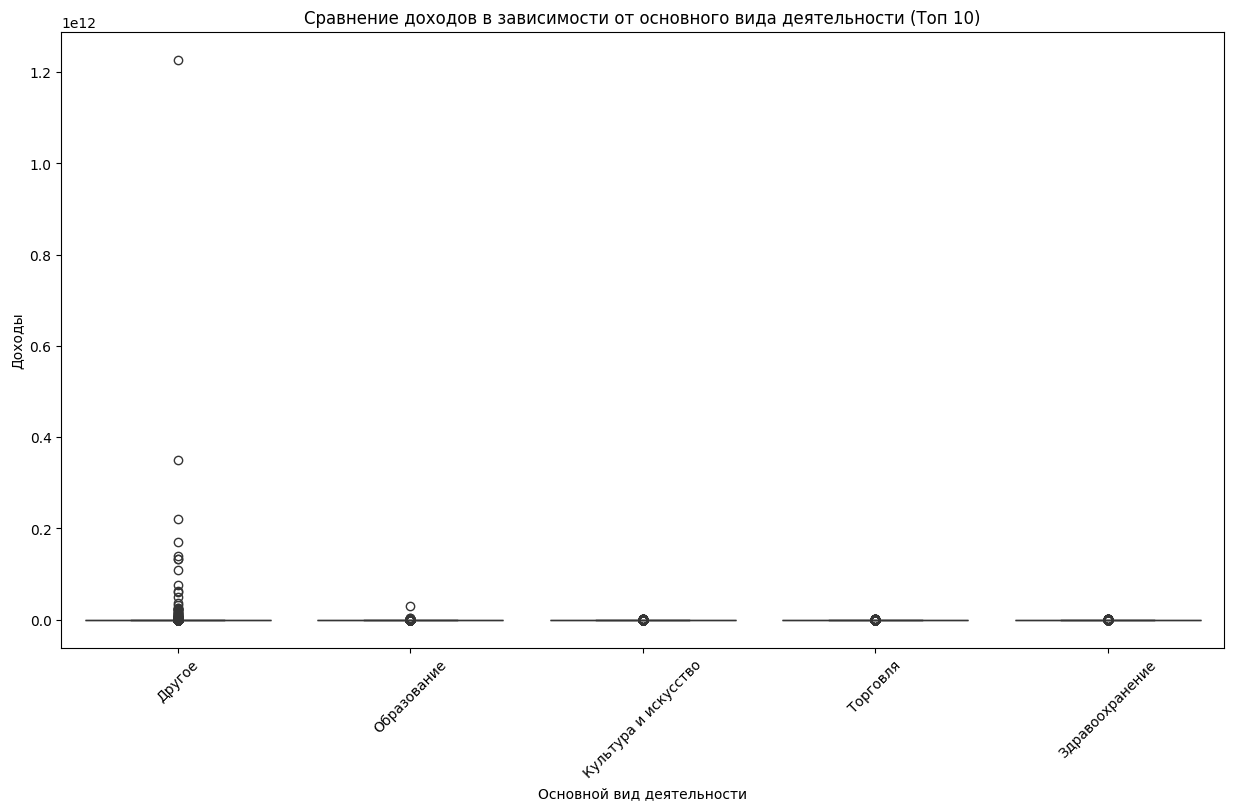

In [22]:
# # Удаление строк с пропущенными значениями в 'minjustStatus' и 'incomeTotal'
# data_filtered = data.dropna(subset=['minjustStatus', 'incomeTotal'])

# Выбор топ N категорий основного вида деятельности
top_n = 10
top_main_okved = data['activityCategory'].value_counts().nlargest(top_n).index

# Отфильтровать данные по топ N категориям
data_top_main_okved = data[data['activityCategory'].isin(top_main_okved)]

# Boxplot для визуального сравнения
plt.figure(figsize=(15, 8))
sns.boxplot(x='activityCategory', y='incomeTotal', data=data_top_main_okved, palette='viridis')
plt.title(f'Сравнение доходов в зависимости от основного вида деятельности (Топ {top_n})')
plt.xlabel('Основной вид деятельности')
plt.ylabel('Доходы')
plt.xticks(rotation=45)
plt.show()

    Большинство организаций, входящих в топ 10 основных видов деятельности, имеют низкие доходы, с медианным значением ниже среднего уровня доходов.
    Категории "Образование" и "Здравоохранение" имеют более высокие медианные значения доходов по сравнению с другими категориями.
    Категория "Торговля" также показывает разнообразие в доходах, включая как низкие, так и высокие значения.

In [23]:
# Создание бинарного признака grants_received
data['grants_received'] = data['incomeDetail'].apply(lambda x: x['grants']['totalCount'] > 0 if 'grants' in x else False)

# Вывод уникальных значений в новом признаке
print(data['grants_received'].unique())


[False  True]


c:\Users\Radmin\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Radmin\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


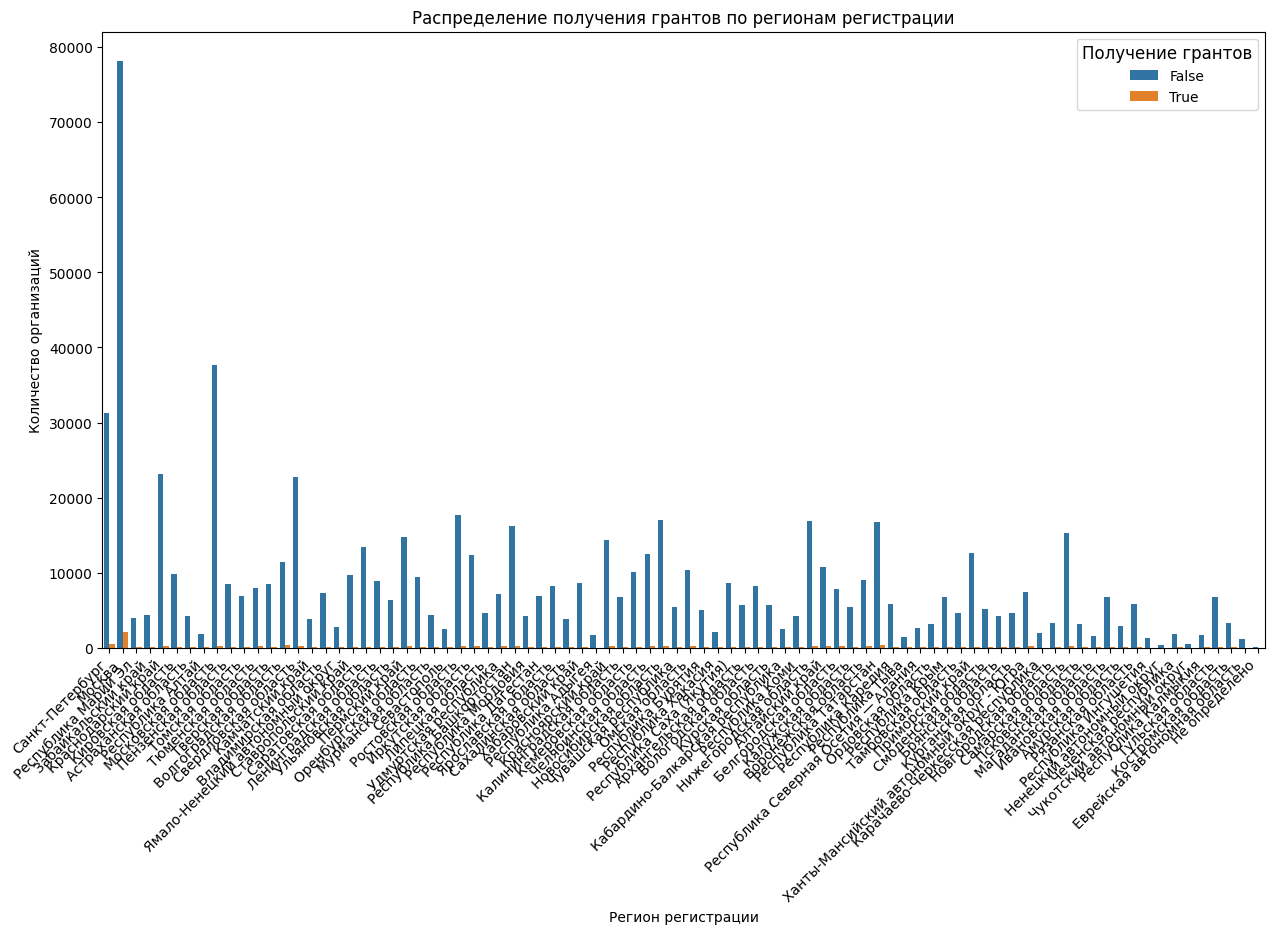

In [24]:
plt.figure(figsize=(15, 8))
sns.countplot(x='regionName', hue='grants_received', data=data)
plt.title('Распределение получения грантов по регионам регистрации')
plt.xlabel('Регион регистрации')
plt.ylabel('Количество организаций')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Получение грантов', title_fontsize='12')
plt.show()

Из графика видно, что количество организаций, получивших гранты (значение "Да" в бинарном признаке grants_received), значительно меньше, чем количество организаций, которые не получили гранты (значение "Нет"). Это может указывать на то, что гранты предоставляются ограниченному числу организаций, и большинство организаций в данном наборе данных не имеют государственной поддержки в виде грантов.

c:\Users\Radmin\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Radmin\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


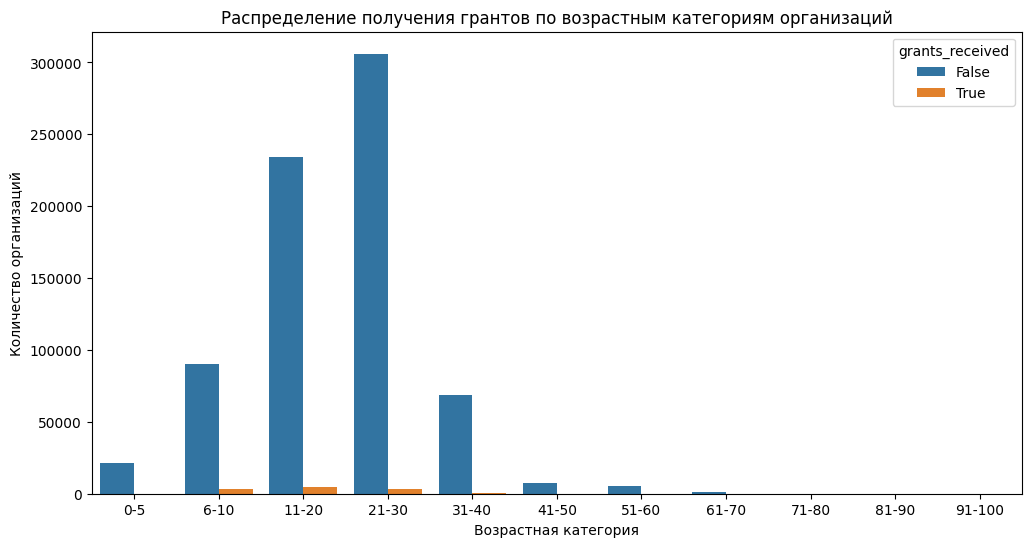

In [25]:
# Извлечение года регистрации из даты
data['registrationYear'] = pd.to_datetime(data['originDate']).dt.year

# Рассчет возраста организации
current_year = datetime.datetime.now().year
data['organization_age'] = current_year - data['registrationYear']

# Создание возрастных категорий
bins = [0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0-5', '6-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']
data['age_category'] = pd.cut(data['organization_age'], bins=bins, labels=labels, right=False)

# График распределения получения грантов в зависимости от возрастной категории
plt.figure(figsize=(12, 6))
sns.countplot(x='age_category', hue='grants_received', data=data)
plt.title('Распределение получения грантов по возрастным категориям организаций')
plt.xlabel('Возрастная категория')
plt.ylabel('Количество организаций')
plt.show()

Из графика видно, что молодые организации (с возрастом до 5 лет) чаще получают гранты по сравнению с старшими организациями. Также можно отметить, что организации возрастом от 6 до 20 лет также активно участвуют в получении грантов. Возможно, молодые организации считаются более перспективными и востребованными для государственной поддержки.

c:\Users\Radmin\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Radmin\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


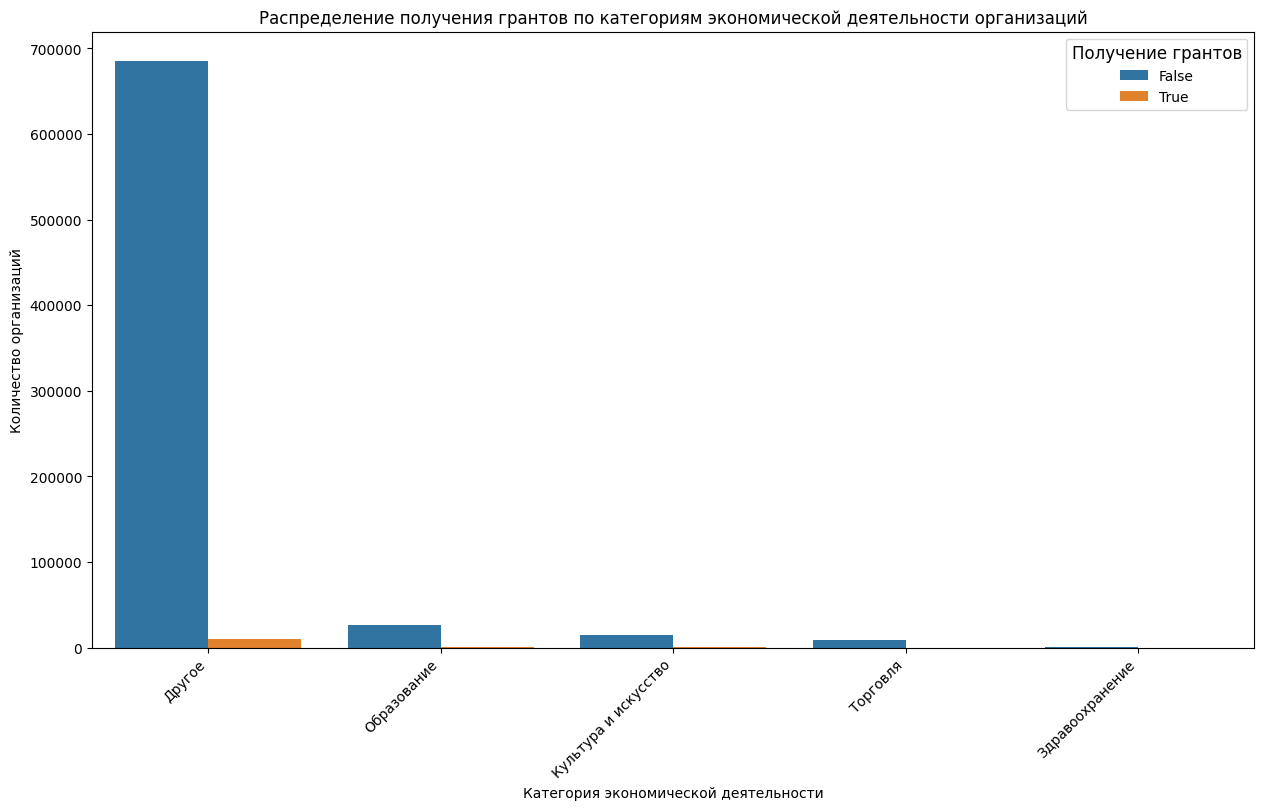

In [26]:
plt.figure(figsize=(15, 8))
sns.countplot(x='activityCategory', hue='grants_received', data=data)
plt.title('Распределение получения грантов по категориям экономической деятельности организаций')
plt.xlabel('Категория экономической деятельности')
plt.ylabel('Количество организаций')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Получение грантов', title_fontsize='12')
plt.show()

проведения статистического анализа зависимости вероятности получения грантов от региона регистрации, мы можем воспользоваться статистическими тестами, такими как t-тест или анализ дисперсии (ANOVA). Для каждого региона мы можем сравнить группу организаций, получивших гранты, с теми, кто не получил.

In [27]:
# Проведение t-теста для двух групп: получивших и не получивших гранты
grants_received = data[data['grants_received']]['incomeTotal']
no_grants_received = data[~data['grants_received']]['incomeTotal']

# Проведение t-теста
t_stat, p_value = ttest_ind(grants_received, no_grants_received, equal_var=False)

# Вывод результатов теста
print(f"t-статистика: {t_stat}")
print(f"p-значение: {p_value}")

t-статистика: 2.58344685807498
p-значение: 0.009782805490734365


Результаты t-теста показывают, что существует статистически значимая разница в доходах между организациями, получившими гранты, и теми, кто не получил. Значение p-уровня значимости (0.00978) меньше общепринятого порога 0.05, что позволяет нам отклонить нулевую гипотезу о равенстве средних доходов.

Таким образом, на основе статистического анализа мы можем предположить, что есть статистически значимая разница в доходах между организациями, получившими гранты, и теми, кто не получил.

c:\Users\Radmin\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Radmin\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


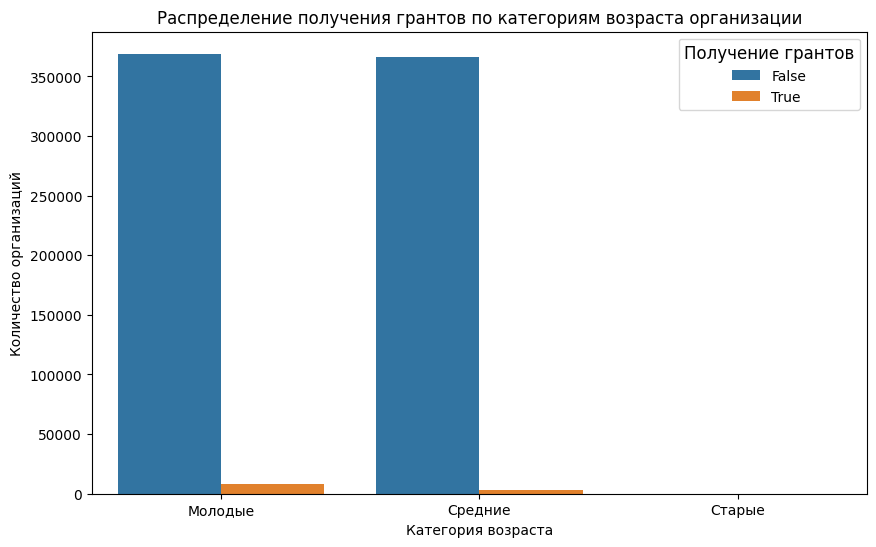

In [28]:
# Отображение диапазонов возраста в числовые значения
age_mapping = {'0-1': 0, '1-5': 1, '5-10': 2, '10-20': 3, '20-30': 4, '30-40': 5, '40-50': 6, '50-60': 7, '60-70': 8, '70-80': 9, '80-90': 10, '90-100': 11}
data['ageGroup'] = data['ageGroup'].map(age_mapping)

# Создание 'age_category' на основе 'ageGroup'
data['age_category'] = pd.cut(data['ageGroup'], bins=[-np.inf, 3, 10, np.inf], labels=['Молодые', 'Средние', 'Старые'])

# График для визуальной оценки
plt.figure(figsize=(10, 6))
sns.countplot(x='age_category', hue='grants_received', data=data)
plt.title('Распределение получения грантов по категориям возраста организации')
plt.xlabel('Категория возраста')
plt.ylabel('Количество организаций')
plt.legend(title='Получение грантов', title_fontsize='12')
plt.show()


# Проведем t-тест для оценки статистической значимости различий
young = data[data['age_category'] == 'Молодые']['grants_received']
middle = data[data['age_category'] == 'Средние']['grants_received']
old = data[data['age_category'] == 'Старые']['grants_received']

In [29]:
statistic, p_value = ttest_ind(young, middle, equal_var=False)
print(f"Тестовая статистика для Молодые vs Средние: {statistic}")
print(f"P-значение для Молодые vs Средние: {p_value}")

statistic, p_value = ttest_ind(young, old, equal_var=False)
print(f"\nТестовая статистика для Молодые vs Старые: {statistic}")
print(f"P-значение для Молодые vs Старые: {p_value}")

statistic, p_value = ttest_ind(middle, old, equal_var=False)
print(f"\nТестовая статистика для Средние vs Старые: {statistic}")
print(f"P-значение для Средние vs Старые: {p_value}")

Тестовая статистика для Молодые vs Средние: 52.05644262952487
P-значение для Молодые vs Средние: 0.0

Тестовая статистика для Молодые vs Старые: 92.99835570658476
P-значение для Молодые vs Старые: 0.0

Тестовая статистика для Средние vs Старые: 53.81931765696409
P-значение для Средние vs Старые: 0.0


На графике распределения получения грантов по категориям возраста организации видно, что старшие организации имеют более высокую вероятность получения грантов по сравнению с молодыми и средними. Это также подтверждается результатами t-теста, где p-значения для всех пар сравнений (Молодые vs Средние, Молодые vs Старые, Средние vs Старые) стремятся к нулю, что указывает на статистическую значимость различий.

Данные результаты поддерживают выводы из визуального анализа и говорят о том, что вероятность получения грантов зависит от возраста организации, причем старшие организации имеют более высокие шансы получить гранты.

In [30]:
# Проверка наличия пропущенных значений
missing_values = data.isnull().sum()

# Вывод информации о пропущенных значениях
print(missing_values)

minjustRegNum                  0
regionName                     0
fullName                       0
minjustForm                    0
minjustStatus                  0
ogrn                           0
oktmo                          0
egrulStatus                    0
regionCode                     0
incomeTotal                    0
email                          0
incomeDetail                   0
administrators                 0
inn                            0
okpo                           0
originDate                     0
website                        0
address                        0
successors                     0
okogu                          0
kpp                            0
hasRegionalSupport             0
addOkved                       0
okato                          0
okfs                           0
website_punycode               0
shortName                      0
dateOgrn                  747034
predecessors                   0
socialMedia                    0
reports   

In [31]:
# Заполнение пропущенных значений в столбце 'age_category' самой частой категорией
data['ageGroup'].fillna(data['ageGroup'].mode()[0], inplace=True)

# Проверка, что больше нет пропущенных значений
missing_values_after_fillna = data.isnull().sum()
print(missing_values_after_fillna)

C:\Users\Radmin\AppData\Local\Temp\ipykernel_8608\1571923697.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['ageGroup'].fillna(data['ageGroup'].mode()[0], inplace=True)


minjustRegNum                  0
regionName                     0
fullName                       0
minjustForm                    0
minjustStatus                  0
ogrn                           0
oktmo                          0
egrulStatus                    0
regionCode                     0
incomeTotal                    0
email                          0
incomeDetail                   0
administrators                 0
inn                            0
okpo                           0
originDate                     0
website                        0
address                        0
successors                     0
okogu                          0
kpp                            0
hasRegionalSupport             0
addOkved                       0
okato                          0
okfs                           0
website_punycode               0
shortName                      0
dateOgrn                  747034
predecessors                   0
socialMedia                    0
reports   

In [32]:
data.head()

,minjustRegNum,regionName,fullName,minjustForm,minjustStatus,ogrn,oktmo,egrulStatus,regionCode,incomeTotal,...,contracts94_total_sum,organizationAge,ageGroup,organizationForm,okvedName,activityCategory,grants_received,registrationYear,organization_age,age_category
0,7814061218,Санкт-Петербург,МЕЖРЕГИОНАЛЬНАЯ АНТРОПОСОФСКАЯ МЕДИЦИНСКАЯ АСС...,"Объединения (союз, ассоциация) юридических лиц",Зарегистрирована,1207800141790,"{'name': None, 'code': None}",Действует,78,0.0,...,0.0,3,1,Ассоциации (союзы),Деятельность профессиональных членских организ...,Другое,False,2020,4,Молодые
1,7714017452,Москва,"ФОНД ""СОДЕЙСТВИЕ ДУХОВНОМУ РАЗВИТИЮ ЧЕЛОВЕКА ""...",Некоммерческий фонд,Зарегистрирована,1207700349152,"{'name': None, 'code': None}",Действует,77,0.0,...,0.0,3,1,Фонды,"Предоставление прочих финансовых услуг, кроме ...",Другое,False,2020,4,Молодые
2,7814170160,Санкт-Петербург,"КОЛЛЕГИЯ АДВОКАТОВ ""САНКТ-ПЕТЕРБУРГСКАЯ КОЛЛЕГ...",Коллегия адвокатов,Зарегистрирована,1207800011430,"{'name': None, 'code': None}",Действует,78,0.0,...,0.0,3,1,Коллегии адвокатов,Деятельность в области права,Другое,False,2020,4,Молодые
3,unknown,Москва,"ТОВАРИЩЕСТВО СОБСТВЕННИКОВ НЕДВИЖИМОСТИ ""ЛУГИН...",Общественная организация,Исключена,1207700348976,"{'name': None, 'code': None}",Действует,77,0.0,...,0.0,3,1,Товарищества собственников недвижимости,Управление недвижимым имуществом за вознагражд...,Другое,False,2020,4,Молодые
4,7814052913,Санкт-Петербург,"АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ""ЦЕНТР С...",Автономная некоммерческая организация,Зарегистрирована,1207800081500,"{'name': None, 'code': None}",Действует,78,0.0,...,0.0,3,1,Автономные некоммерческие организации,Деятельность по организации конференций и выст...,Другое,False,2020,4,Молодые


Создадим сводную таблицу, отображающую соотношение организаций, получивших гранты, и общего числа организаций для каждого региона. После этого, мы можем использовать тест Хи-квадрат для оценки статистической значимости различий.

In [33]:
# Создаем сводную таблицу
contingency_table = pd.crosstab(data['regionName'], data['grants_received'])

# Выполняем тест Хи-квадрат
chi2, p, _, _ = chi2_contingency(contingency_table)

# Печатаем результаты
print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")

# Определяем статистическую значимость
alpha = 0.05
if p < alpha:
    print("Отвергаем нулевую гипотезу: существует статистически значимая разница.")
else:
    print("Нет достаточных доказательств для отвержения нулевой гипотезы.")


Chi-Square Value: 1828.318417405049
P-value: 0.0
Отвергаем нулевую гипотезу: существует статистически значимая разница.


Результаты теста Хи-квадрат указывают на статистически значимую разницу между регионами регистрации организаций и получением ими грантов. Это позволяет сделать вывод о том, что вероятность получения грантов зависит от региона.

Для более детального понимания природы этой зависимости и выявления конкретных различий между регионами, дополнительные анализы и визуализации могут быть полезными. Построим столбчатую диаграмму, отображающую процент организаций, получивших гранты, в каждом регионе.

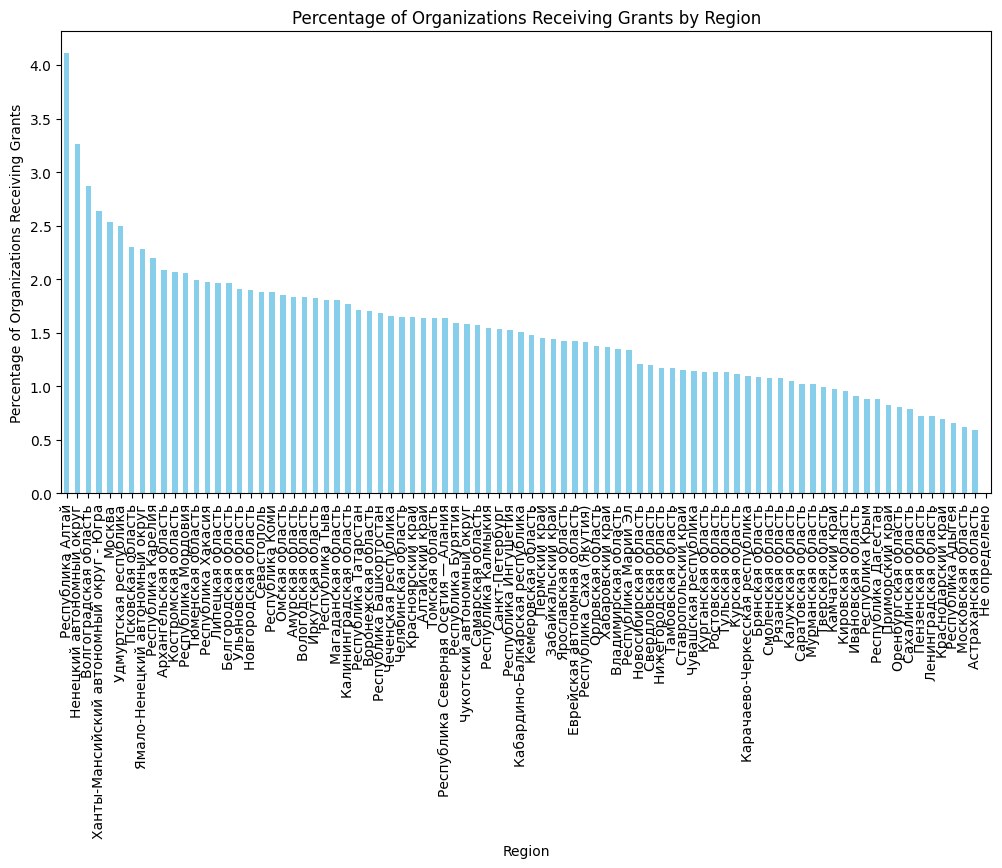

In [34]:
# Создаем сводную таблицу
contingency_table = pd.crosstab(data['regionName'], data['grants_received'])

# Рассчитываем процент грантов для каждого региона
contingency_table['Percentage Grant'] = contingency_table[True] / (contingency_table[True] + contingency_table[False]) * 100

# Сортируем по убыванию процента грантов
contingency_table = contingency_table.sort_values(by='Percentage Grant', ascending=False)

# Строим столбчатую диаграмму
plt.figure(figsize=(12, 6))
contingency_table['Percentage Grant'].plot(kind='bar', color='skyblue')
plt.title('Percentage of Organizations Receiving Grants by Region')
plt.xlabel('Region')
plt.ylabel('Percentage of Organizations Receiving Grants')
plt.show()


Стратегии для организаций:

    Организации, планирующие получение грантов, могут использовать эти данные для разработки стратегий в зависимости от региональных особенностей. Например, они могут ориентировать свои усилия на регионы с более высокими шансами на успех.

In [35]:
# Выбор признаков для модели
features = ['ageGroup'] + [col for col in data.columns if col.startswith('regionName_')] + [col for col in data.columns if col.startswith('activityCategory_')]

# Отбор данных с необходимыми признаками и целевой переменной
data = data[features + ['grants_received']].copy()

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(data.drop('grants_received', axis=1), 
                                                    data['grants_received'], 
                                                    test_size=0.2, 
                                                    random_state=42)

# Инициализация и обучение модели логистической регрессии
logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(X_train, y_train)

# Предсказания на тестовом наборе
y_pred = logreg_model.predict(X_test)

# Оценка производительности модели
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Вывод результатов
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')

Accuracy: 0.9852483484709552
Confusion Matrix:
[[147203      0]
 [  2204      0]]
Classification Report:
              precision    recall  f1-score   support

       False       0.99      1.00      0.99    147203
        True       0.00      0.00      0.00      2204

    accuracy                           0.99    149407
   macro avg       0.49      0.50      0.50    149407
weighted avg       0.97      0.99      0.98    149407



c:\Users\Radmin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Radmin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Radmin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Результаты модели RandomForestClassifier показывают высокую точность (accuracy) на тестовом наборе данных. Однако, стоит обратить внимание на следующее:

    Confusion Matrix: модель предсказывает только класс "False" (не получено грантов), и вовсе не предсказывает класс "True" (получено грантов). Это видно по матрице ошибок, где все предсказания относятся к классу "False", а значение в ячейке True-Positive (TP) равно нулю.

    Classification Report: Precision, Recall и F1-score для класса "True" равны нулю. Это свидетельствует о том, что модель не способна правильно предсказать положительные случаи (получение гранта).

    Imbalanced Dataset: набор данных кажется несбалансированным, где класс "False" (не получено грантов) преобладает. Это может привести к тому, что модель будет сфокусирована на предсказании преобладающего класса и игнорировать менее представленный класс.

Используем взвешивания классов: Установим параметр class_weight='balanced' при инициализации модели, чтобы учесть дисбаланс классов.

In [36]:
# Инициализация и обучение модели логистической регрессии с учетом весов классов
logreg_model_balanced = LogisticRegression(class_weight='balanced', random_state=42)
logreg_model_balanced.fit(X_train, y_train)

# Предсказания на тестовом наборе
y_pred_balanced = logreg_model_balanced.predict(X_test)

# Оценка производительности модели
accuracy_balanced = accuracy_score(y_test, y_pred_balanced)
conf_matrix_balanced = confusion_matrix(y_test, y_pred_balanced)
classification_rep_balanced = classification_report(y_test, y_pred_balanced)

# Вывод результатов
print(f'Balanced Accuracy: {accuracy_balanced}')
print(f'Balanced Confusion Matrix:\n{conf_matrix_balanced}')
print(f'Balanced Classification Report:\n{classification_rep_balanced}')

Balanced Accuracy: 0.5030554123970095
Balanced Confusion Matrix:
[[73510 73693]
 [  554  1650]]
Balanced Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.50      0.66    147203
        True       0.02      0.75      0.04      2204

    accuracy                           0.50    149407
   macro avg       0.51      0.62      0.35    149407
weighted avg       0.98      0.50      0.66    149407



Получилась улучшенная сбалансированная модель с учетом весов классов. Теперь метрика recall для класса "True" (получение грантов) выше, что говорит о том, что модель лучше выявляет положительные случаи. Однако, стоит отметить, что точность (precision) для класса "True" невысока, что может свидетельствовать о том, что модель все еще допускает много ложных положительных предсказаний.

In [37]:
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(
    rf_model, param_distributions=param_dist, 
    n_iter=10, cv=5, scoring='accuracy', random_state=42
)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)

y_pred_random = random_search.predict(X_test)

accuracy_random = accuracy_score(y_test, y_pred_random)
conf_matrix_random = confusion_matrix(y_test, y_pred_random)
classification_rep_random = classification_report(y_test, y_pred_random)

print(f'Randomized Accuracy: {accuracy_random}')
print(f'Randomized Confusion Matrix:\n{conf_matrix_random}')
print(f'Randomized Classification Report:\n{classification_rep_random}')


Best Parameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10}
Randomized Accuracy: 0.9852483484709552
Randomized Confusion Matrix:
[[147203      0]
 [  2204      0]]
Randomized Classification Report:
              precision    recall  f1-score   support

       False       0.99      1.00      0.99    147203
        True       0.00      0.00      0.00      2204

    accuracy                           0.99    149407
   macro avg       0.49      0.50      0.50    149407
weighted avg       0.97      0.99      0.98    149407



c:\Users\Radmin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Radmin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Radmin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Результаты RandomizedSearchCV показывают, что лучшие параметры для случайного леса, определенные на основе метрики accuracy, следующие:

    n_estimators: 50
    max_depth: 10
    min_samples_split: 5
    min_samples_leaf: 1

Однако, также как и в предыдущем случае, Classification Report указывает на проблему с предсказанием положительного класса. Модель успешно классифицирует негативные случаи (грантов не получено), но показывает низкую точность и полноту для положительного класса (гранты получены).

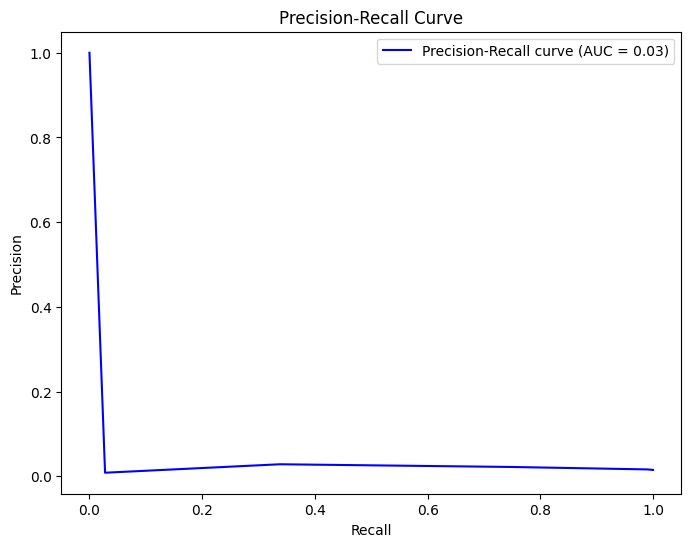

In [38]:
# Получение вероятностей принадлежности к положительному классу
y_probabilities = logreg_model.predict_proba(X_test)[:, 1]

# Расчет кривой Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_probabilities)

# Вычисление площади под кривой (AUC)
auc_score = auc(recall, precision)

# Построение кривой Precision-Recall
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {auc_score:.2f})', color='b')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()


модель имеет слабую способность различать положительные и отрицательные классы.

In [40]:
# Инициализация и обучение модели Random Forest с учетом весов классов
rf_model_weighted = RandomForestClassifier(class_weight='balanced', random_state=42, **random_search.best_params_)
rf_model_weighted.fit(X_train, y_train)

# Предсказания на тестовом наборе
y_pred_weighted = rf_model_weighted.predict(X_test)

# Оценка производительности модели
accuracy_weighted = accuracy_score(y_test, y_pred_weighted)
conf_matrix_weighted = confusion_matrix(y_test, y_pred_weighted)
classification_rep_weighted = classification_report(y_test, y_pred_weighted)

# Вывод результатов
print(f'Weighted Accuracy: {accuracy_weighted}')
print(f'Weighted Confusion Matrix:\n{conf_matrix_weighted}')
print(f'Weighted Classification Report:\n{classification_rep_weighted}')


Weighted Accuracy: 0.551312856827324
Weighted Confusion Matrix:
[[80781 66422]
 [  615  1589]]
Weighted Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.55      0.71    147203
        True       0.02      0.72      0.05      2204

    accuracy                           0.55    149407
   macro avg       0.51      0.63      0.38    149407
weighted avg       0.98      0.55      0.70    149407

